# Decision Tree Example using atmospheric data from Christman Field

* Iris example adapted from: https://www.datacamp.com/community/tutorials/random-forests-classifier-python
* Further modified by: Aaron Hill and Wei-Ting Hsiao (Dept. of Atmospheric Science, Colorado State University), January 2020
* Further adapted by: Prof. Elizabeth Barnes for ATS 780A7 Spring 2022 at Colorado State University

Lets import some libraries we will need throughout this tutorial:



In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = False


In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import datetime
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
import pydot
import matplotlib.pyplot as plt
# %matplotlib inline

In [3]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"scikit-learn version = {sklearn.__version__}")  

python version = 3.7.11 (default, Jul 27 2021, 07:03:16) 
[Clang 10.0.0 ]
numpy version = 1.21.5
scikit-learn version = 1.0.2


In [4]:
if(IN_COLAB==True):
    # 1. Make the path of your own Google Drive accessible
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    local_path = '/content/drive/My Drive/Colab Notebooks/'
else:
    local_path = 'figures/'

# 1. Data Preparation

### 1.1 Data overview

We have stored a .csv file on a CSU drive, accessible via URL. This will be the basis for our tutorial. This file contains Fort Collins weather data from 2018, and we will use these data to predict the high temperature for a given day with a random forest regression model.  

In [5]:
# Read in data from url
url = "http://schumacher.atmos.colostate.edu/hilla/temps_FC.csv"
data = pd.read_csv(url)

Lets look at our data to see what we are working with

In [6]:
# Display first 5 rows
print('The shape of our features is:', data.shape)
data.head(5)

The shape of our features is: (365, 11)


,YEAR,MONTH,DAY,TMAX,TMIN,TMAX_1d,TMAX_2d,TMAX_BD,TMAX_SF,PRCP,TMAX_CLIM
0,2018,1,1,26,10,31,24,30,61,0.0,43.5
1,2018,1,2,41,5,26,31,46,61,0.0,43.6
2,2018,1,3,47,12,41,26,50,58,0.0,43.7
3,2018,1,4,51,18,47,41,52,63,0.0,43.8
4,2018,1,5,50,21,51,47,62,61,0.0,43.9


You will notice we have 365 days of features and labels (complete set from 2018). Our second features axis is the columns of the pandas dataframe. These columns represent the year, month, day, maximum temperature, minimum temperature, max temp from day before, max temp from two days prior, max temperature in Boulder, max temperature in San Francisco, precipitation, and climatological maximum. 

The max temperature column (TMAX) is actually our label: the observed max temperature at Fort Collins.

We can look quickly at some basic statistics of our data, such as mean, standard deviation, percentiles, etc. in a table format

In [7]:
# A handy tool in pandas: descriptive statistics for each column
data.describe()

,YEAR,MONTH,DAY,TMAX,TMIN,TMAX_1d,TMAX_2d,TMAX_BD,TMAX_SF,PRCP,TMAX_CLIM
count,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,2018.0,6.526027,15.720548,65.652055,37.389041,65.627397,65.564384,66.876712,63.904110,0.037260,63.738356
std,0.0,3.452584,8.808321,18.372280,16.232409,18.412798,18.515789,17.882819,6.004038,0.147239,15.407528
min,2018.0,1.000000,1.000000,15.000000,-3.000000,15.000000,15.000000,15.000000,51.000000,0.000000,42.100000
25%,2018.0,4.000000,8.000000,50.000000,24.000000,50.000000,50.000000,52.000000,60.000000,0.000000,48.100000
50%,2018.0,7.000000,16.000000,65.000000,37.000000,65.000000,65.000000,66.000000,63.000000,0.000000,63.000000
75%,2018.0,10.000000,23.000000,82.000000,52.000000,82.000000,82.000000,83.000000,67.000000,0.000000,78.500000
max,2018.0,12.000000,31.000000,101.000000,68.000000,101.000000,101.000000,98.000000,83.000000,1.740000,87.100000


We have made it so that there is not much to clean up in this dataset...however you may run into a scenario where days are missing, values are missing, etc. wherein you need to remove bad features, labels, or examples (i.e., days of observations). It is often said that 80% of machine learning is the preprocessing of your data. 


### 1.2 Targets and features

The pandas table is handy for a quick glance, but we need to organize some numpy arrays that separately contain our features and labels.

In [8]:
THRESHOLD_TEMP = 65   # default = 65

# Labels are the values we want to predict
labels = (np.array(data['TMAX']) > THRESHOLD_TEMP)

# Remove the labels from the features
# axis 1 refers to the columns
features = data.drop('TMAX', axis = 1)

# Also remove TMAX_BD for later use, you will understand later
features = features.drop('TMAX_BD', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

### 1.3 Splitting training and testing datasets

Assuming we have no feature data available from 2019 we could use to test our trained models against, we will want to split up our dataset into training and testing portions. A standard proportion is 3/4 for training, 1/4 for testing, although this is somewhat arbitrary here. 

In [9]:
# Split the data into training and testing sets

# Tunable Parameter: Describes the proportion of the dataset we want to use for testing. 1 - split_size is used for training. 
split_size = 0.25

# PARAMETERS:
#     test_size: fraction of testing/validation datasets
#     random_state: random parameter
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = split_size, random_state = 42)

Lets quickly check the size of our training and testing arrays are what we expect (and we didn't do something wrong)

In [10]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (273, 9)
Training Labels Shape: (273,)
Testing Features Shape: (92, 9)
Testing Labels Shape: (92,)


# 2. Creating a decision tree

### Train the model and visualize it

In [11]:
# Tunable Parameters for Model
tree_depth = 2 
node_split = 2       # minimum number of training samples needed to split a node
leaf_samples = 1     # minimum number of training samples required to make a leaf node
RAND_STATE = 42

tree_clf = DecisionTreeClassifier(max_depth=tree_depth, 
                                  min_samples_split=node_split,
                                  min_samples_leaf=leaf_samples,
                                  random_state=RAND_STATE,
                                  criterion='gini',  #can also set to 'entropy'
                                 )
tree_clf.fit(train_features,train_labels)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [12]:
fig_savename = 'tree_classifier_christman'
tree = tree_clf

export_graphviz(tree,
                out_file=local_path + fig_savename+'.dot',
                filled=True,
                proportion=False,
                leaves_parallel=False,
                class_names=('below ' + str(THRESHOLD_TEMP),'above ' + str(THRESHOLD_TEMP)),
                feature_names=feature_list)

# Use dot file to create a graph to write to a png
(graph, ) = pydot.graph_from_dot_file(local_path + fig_savename + '.dot')
graph.write_png(local_path + fig_savename + '.png')

### Make predictions

In [13]:
y_pred_train = tree_clf.predict(train_features)
y_pred_test = tree_clf.predict(test_features)
y_pred_test

array([ True, False, False, False, False,  True, False, False,  True,
        True, False, False, False, False,  True, False, False,  True,
       False, False, False,  True, False,  True,  True,  True,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
        True, False, False, False, False,  True, False, False,  True,
        True, False, False, False, False, False,  True, False, False,
       False,  True, False,  True,  True,  True, False, False,  True,
       False,  True, False,  True, False, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
       False, False])

In [14]:
tree_clf.predict_proba(test_features)[:5]

array([[0.        , 1.        ],
       [0.95726496, 0.04273504],
       [0.95726496, 0.04273504],
       [0.95726496, 0.04273504],
       [0.95726496, 0.04273504]])

### Visualization of predictions

In [15]:
def plot_time_series(features, feature_list, labels, test_features, predictions):
    
    # Use datetime for creating date objects for plotting
    # Dates of training values
    months = features[:, feature_list.index('MONTH')]
    days = features[:, feature_list.index('DAY')]
    years = features[:, feature_list.index('YEAR')]
    # List and then convert to datetime object
    dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
    dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
    
    # Dataframe with true values and dates
    true_data = pd.DataFrame(data = {'date': dates, 'TMAX': labels})
    
    # Dates of predictions
    months = test_features[:, feature_list.index('MONTH')]
    days = test_features[:, feature_list.index('DAY')]
    years = test_features[:, feature_list.index('YEAR')]
    
    # Column of dates
    test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
    
    # Convert to datetime objects
    test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
    
    # Dataframe with predictions and dates
    predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
    
    # Plot the actual values
    plt.plot(true_data['date'], true_data['TMAX'], 'b-', label = 'TMAX')
    
    # Plot the predicted values
    plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
    plt.xticks(rotation = '60'); 
    plt.legend()
    
    # Graph labels
    plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Classified Values')
    plt.axhline(y=THRESHOLD_TEMP,linestyle='--')
    plt.show()

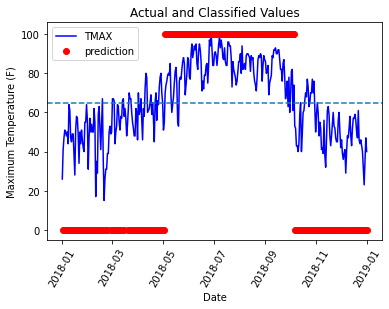

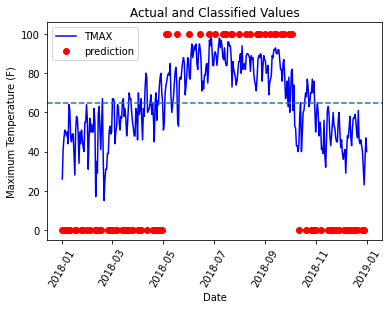

In [16]:
plot_time_series(features, feature_list, np.array(data['TMAX']), train_features, y_pred_train*100)
plot_time_series(features, feature_list, np.array(data['TMAX']), test_features, y_pred_test*100)

### Evaluate the classification predictions

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [18]:
y_probs = tree_clf.predict_proba(test_features)
y_scores = y_probs[:,1]
fpr_tree, tpr_tree, thresholds_tree = roc_curve(test_labels,y_scores)
auc_tree = roc_auc_score(test_labels,y_scores)

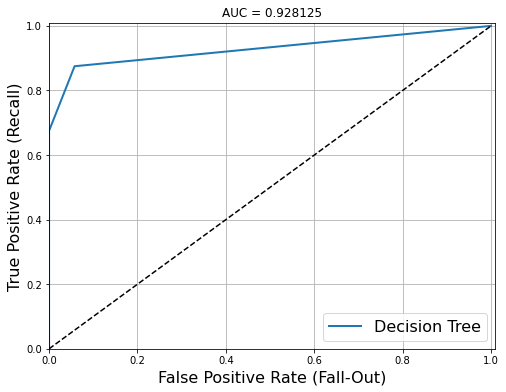

In [19]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1.01, 0, 1.01])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown
    
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_tree, tpr_tree, "Decision Tree")
plt.title('AUC = ' + str(auc_tree))
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

training confusion matrix
[[127   7]
 [ 18 121]]


Text(0.5, 1.0, 'Training Data')

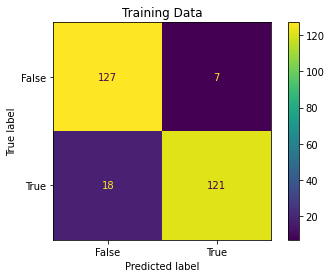

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_train = tree_clf.predict(train_features)
print('training confusion matrix')
print(confusion_matrix(train_labels, y_pred_train))
ConfusionMatrixDisplay.from_predictions(train_labels, y_pred_train)
plt.title('Training Data')

testing confusion matrix
[[52  0]
 [13 27]]


Text(0.5, 1.0, 'Testing Data')

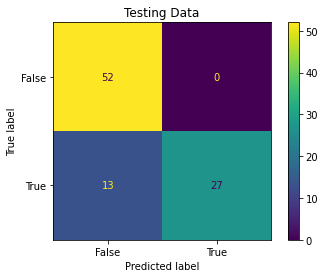

In [21]:
y_pred_test = tree_clf.predict(test_features)
print('testing confusion matrix')
print(confusion_matrix(test_labels, y_pred_test))

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_test)
plt.title('Testing Data')

In [22]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(train_labels, y_pred_train))
print(precision_score(test_labels, y_pred_test))

0.9453125
1.0


In [23]:
print(recall_score(train_labels, y_pred_train))
print(recall_score(test_labels, y_pred_test))

0.8705035971223022
0.675


In [24]:
from sklearn.metrics import f1_score

print(f1_score(train_labels, y_pred_train))
print(f1_score(test_labels, y_pred_test))

0.906367041198502
0.8059701492537313
